# GAN Basic

- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks(https://arxiv.org/pdf/1511.06434.pdf)
- Multi-GPU 사용법
- Sequential에 OrderedDict를 전달하는 예시

![대체 텍스트](http://www.codingwoman.com/wp-content/uploads/2018/09/gan-2-700x529.jpg)

In [1]:
#!pip install torch torchvision

In [2]:
#!pip install pillow==4.1.1
#%reload_ext autoreload
#%autoreload

## 1. Import required libraries

In [3]:
# 단순한 GAN 모델 생성 및 OrderedDict 사용법

import os
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [4]:
# 참고
# 전치 컨볼루션 연산으로 이미지 크기를 2배로 늘리는 방법 2가지
# 둘중에 kernel_size=4,stride=2,padding=1 세팅이 체커보드 아티팩트가 덜합니다.

test = torch.ones(1,1,16,16)
conv1 = nn.ConvTranspose2d(1,1,kernel_size=4,stride=2,padding=1)
out = conv1(test)
print(out.size())

conv1 = nn.ConvTranspose2d(1,1,kernel_size=3,stride=2,padding=1,output_padding=1)
out = conv1(test)
print(out.size())

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])


## 2. Hyperparameter setting

In [5]:
# Set Hyperparameters
# change num_gpu to the number of gpus you want to use

epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1
z_size = 50
middle_size = 200

## 3. Data Setting

In [6]:
# Download Data

mnist_train = dset.MNIST("../../data", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

## 4. Generator

In [7]:
# Generator receives random noise z and create 1x28x28 image
# OrderedDict를 사용해 해당 연산의 이름을 지정할 수 있습니다.

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('fc1',nn.Linear(z_size,middle_size)),
                        ('bn1',nn.BatchNorm1d(middle_size)),
                        ('act1',nn.ReLU()),
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('fc2', nn.Linear(middle_size,784)),
                        #('bn2', nn.BatchNorm1d(784)),
                        ('tanh', nn.Tanh()),
        ]))
    def forward(self,z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = out.view(batch_size,1,28,28)
        return out

## 5. Discriminator

In [8]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('fc1',nn.Linear(784,middle_size)),
                        #('bn1',nn.BatchNorm1d(middle_size)),
                        ('act1',nn.LeakyReLU()),  
            
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('fc2', nn.Linear(middle_size,1)),
                        ('bn2', nn.BatchNorm1d(1)),
                        ('act2', nn.Sigmoid()),
        ]))
                                    
    def forward(self,x):
        out = x.view(batch_size, -1)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

## 6. Put instances on Multi-gpu

In [9]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

generator = nn.DataParallel(Generator()).to(device)
discriminator = nn.DataParallel(Discriminator()).to(device)

cuda


## 7. Check layers

In [10]:
# Get parameter list by using class.state_dict().keys()

gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

module.layer1.fc1.weight
module.layer1.fc1.bias
module.layer1.bn1.weight
module.layer1.bn1.bias
module.layer1.bn1.running_mean
module.layer1.bn1.running_var
module.layer1.bn1.num_batches_tracked
module.layer2.fc2.weight
module.layer2.fc2.bias


## 8. Set Loss function & Optimizer

In [11]:
# loss function, optimizers, and labels for training

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

ones_label = torch.ones(batch_size,1).to(device)
zeros_label = torch.zeros(batch_size,1).to(device)

## 9. Restore Model

In [12]:
# model restore if any

try:
    generator, discriminator = torch.load('./model/vanilla_gan.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass
  
try:
    os.mkdir("./model")
except:
    pass

try:
    os.mkdir("./result")
except:
    pass


--------model not restored--------



## 10. Train Model

In [13]:
# train

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = image.to(device)
        
        # 구분자 학습
        dis_optim.zero_grad()
      
        # Fake Data 
        # 랜덤한 z를 샘플링해줍니다.
        z = init.normal_(torch.Tensor(batch_size,z_size),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        # Real Data
        dis_real = discriminator.forward(image)
        
        # 두 손실을 더해 최종손실에 대해 기울기 게산을 합니다.
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward(retain_graph=True)
        dis_optim.step()
        
        # 생성자 학습
        gen_optim.zero_grad()
        
        # Fake Data
        z = init.normal_(torch.Tensor(batch_size,z_size),mean=0,std=0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward()
        gen_optim.step()
    
        # model save
        if j % 10000 == 0:
            print(gen_loss,dis_loss)
            torch.save([generator,discriminator],'./model/vanilla_gan.pkl')            
            v_utils.save_image(gen_fake.cpu().data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)
            print("{}th epoch gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))

tensor(0.2689, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\my\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\my\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0th epoch gen_loss: 0.2689220905303955 dis_loss: 0.5363640189170837
tensor(0.2545, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5162, device='cuda:0', grad_fn=<AddBackward0>)
1th epoch gen_loss: 0.2545449733734131 dis_loss: 0.5162169933319092
tensor(0.2650, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)
2th epoch gen_loss: 0.26501545310020447 dis_loss: 0.49705976247787476
tensor(0.2530, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)
3th epoch gen_loss: 0.2529567778110504 dis_loss: 0.5092536211013794
tensor(0.2675, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)
4th epoch gen_loss: 0.26749154925346375 dis_loss: 0.49446070194244385
tensor(0.2672, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)
5th epoch gen_loss: 0.2672185003757477 dis_loss: 0.49457162618637085
tensor(0.2515, device='cuda

# Do not expect much on this naive GAN 
- 네트워크 구조에서 봤듯이 거의 학습이 되지 않습니다.
- 여기에 convolution 연산을 추가하면 성능이 올라가는데 이는 DCGAN 코드에서 확인하세요.

0


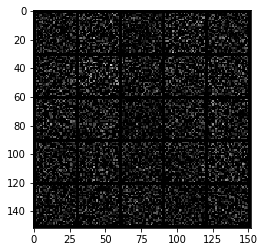

1


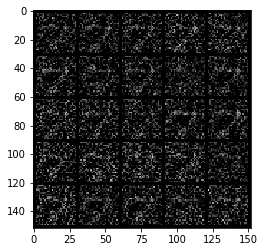

2


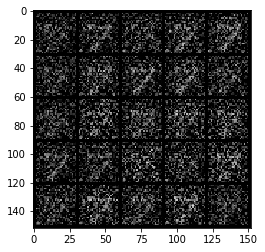

3


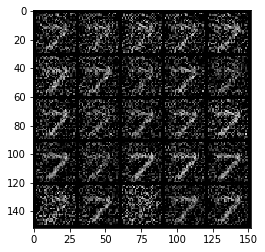

4


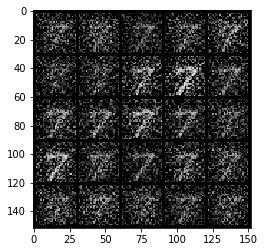

5


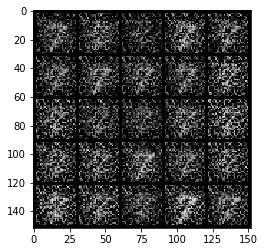

6


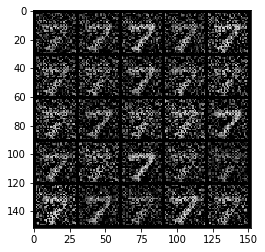

7


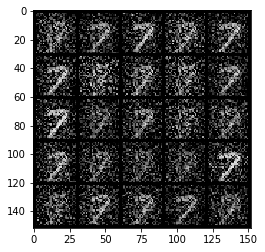

8


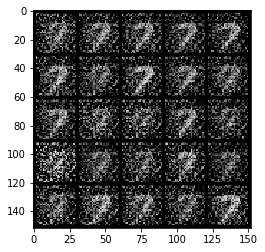

9


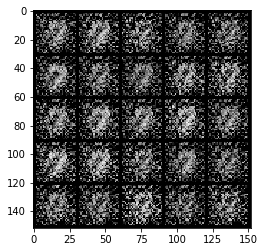

10


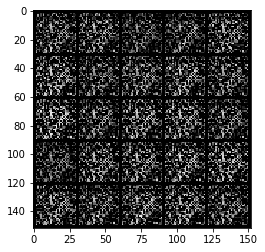

11


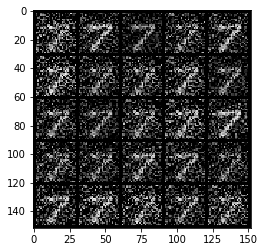

12


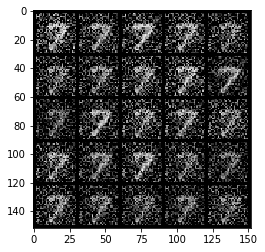

13


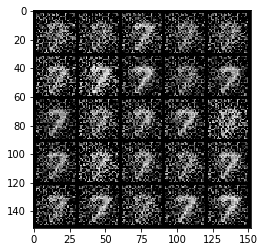

14


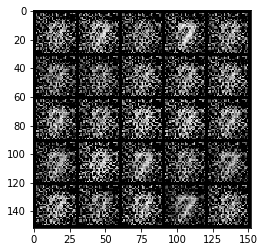

15


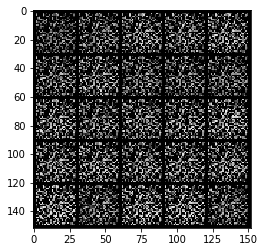

16


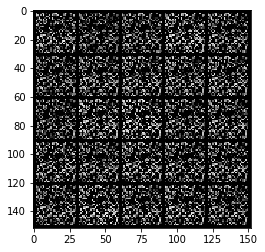

17


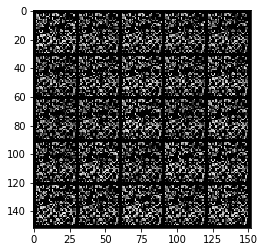

18


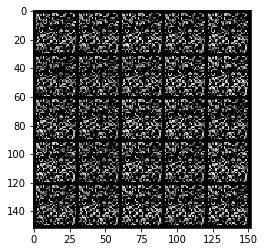

19


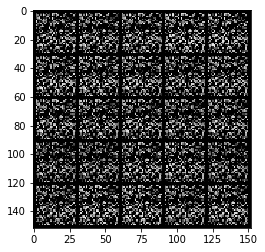

20


In [17]:
from glob import glob 

for i in range(epoch):
    print(i)
    file_list = glob("./result/gen_{}_*.png".format(i))
    img_per_epoch = len(file_list)
    if i == 20:
        break
    for idx,j in enumerate(file_list):
        img = plt.imread(j)
        plt.subplot(1,img_per_epoch,idx+1)
        plt.imshow(img)
    plt.show()